In [1]:
!pip install -q jcopdl
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"achmadjaelani","key":"dd189eefc225838464d0d97aac573496"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d alfanme/indonesian-batik-motifs-corak-app

 83% 129M/156M [00:06<00:01, 19.9MB/s]
100% 156M/156M [00:06<00:00, 25.2MB/s]


In [3]:
!unzip -q -n /content/indonesian-batik-motifs-corak-app.zip

In [4]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [6]:
def inverse_norm(img):
    img[0, :, :] = img[0, :, :] * 0.229 + 0.485
    img[1, :, :] = img[1, :, :] * 0.224 + 0.456
    img[2, :, :] = img[2, :, :] * 0.225 + 0.406
    return img

In [7]:
bs = 16
crop_size = 224

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomVerticalFlip(0.2),
    transforms.RandomHorizontalFlip(0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set = datasets.ImageFolder("DATASETv7/TRAIN/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

test_set = datasets.ImageFolder("DATASETv7/TEST/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [8]:
from torchvision.models import mobilenet_v3_large

In [9]:
class MobileNetv3_small(nn.Module):
    def __init__(self):
        super().__init__()
        self.mnet = mobilenet_v3_large(pretrained=True)
        self.freeze()
        self.mnet.classifier = nn.Sequential(
            nn.Linear(960, 1280),
            nn.Hardswish(),
            nn.Dropout(0.2, inplace=True),
            nn.Linear(1280, 15),
            nn.LogSoftmax()
        )
        
    def forward(self, x):
        return self.mnet(x)
    
    def freeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = False
    
    def unfreeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = True

In [10]:
config = set_config({
    "batch_size": bs,
    "crop_size": crop_size
})

model = MobileNetv3_small().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
callback = Callback(model, config, outdir="model", early_stop_patience=2)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

In [11]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/66 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 2.4346 | Test_cost  = 2.1394 | Train_score = 0.2990 | Test_score = 0.5067 |


Train:   0%|          | 0/66 [00:00<?, ?it/s]

Test:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 1.8443 | Test_cost  = 1.5622 | Train_score = 0.6124 | Test_score = 0.6833 |


Train:   0%|          | 0/66 [00:00<?, ?it/s]

Test:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 1.4549 | Test_cost  = 1.2344 | Train_score = 0.6505 | Test_score = 0.6967 |


Train:   0%|          | 0/66 [00:00<?, ?it/s]

Test:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 1.1583 | Test_cost  = 0.9943 | Train_score = 0.7190 | Test_score = 0.7433 |


Train:   0%|          | 0/66 [00:00<?, ?it/s]

Test:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 1.0333 | Test_cost  = 0.8720 | Train_score = 0.7390 | Test_score = 0.7600 |


Train:   0%|          | 0/66 [00:00<?, ?it/s]

Test:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.9277 | Test_cost  = 0.8126 | Train_score = 0.7371 | Test_score = 0.7700 |


Train:   0%|          | 0/66 [00:00<?, ?it/s]

Test:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.8508 | Test_cost  = 0.7810 | Train_score = 0.7619 | Test_score = 0.7700 |
==> EarlyStop patience =  1 | Best test_score: 0.7700


Train:   0%|          | 0/66 [00:00<?, ?it/s]

Test:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.7822 | Test_cost  = 0.7485 | Train_score = 0.7800 | Test_score = 0.7667 |
==> EarlyStop patience =  2 | Best test_score: 0.7700
==> Execute Early Stopping at epoch: 8 | Best test_score: 0.7700
==> Best model is saved at model


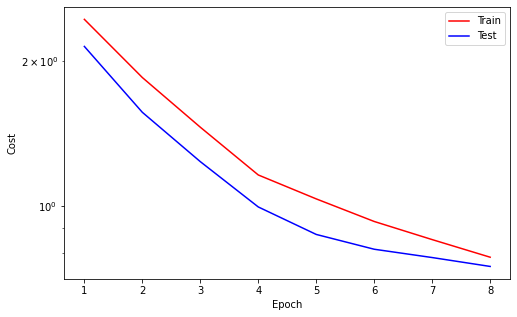

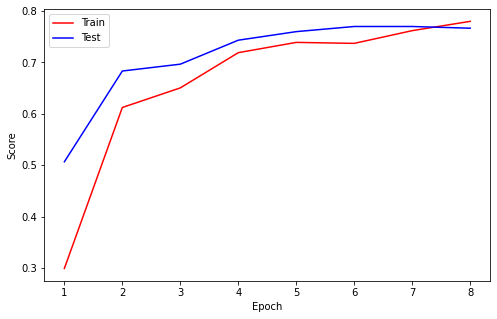

In [12]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# Fine Tuning

In [13]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-6)

callback.reset_early_stop()
callback.early_stop_patience = 7

Train:   0%|          | 0/66 [00:00<?, ?it/s]

Test:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.8290 | Test_cost  = 0.8080 | Train_score = 0.7695 | Test_score = 0.7633 |
==> EarlyStop patience =  1 | Best test_score: 0.7700


Train:   0%|          | 0/66 [00:00<?, ?it/s]

Test:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.8025 | Test_cost  = 0.8033 | Train_score = 0.7810 | Test_score = 0.7633 |
==> EarlyStop patience =  2 | Best test_score: 0.7700


Train:   0%|          | 0/66 [00:00<?, ?it/s]

Test:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.8054 | Test_cost  = 0.7998 | Train_score = 0.7914 | Test_score = 0.7600 |
==> EarlyStop patience =  3 | Best test_score: 0.7700


Train:   0%|          | 0/66 [00:00<?, ?it/s]

Test:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.8220 | Test_cost  = 0.7954 | Train_score = 0.7790 | Test_score = 0.7567 |
==> EarlyStop patience =  4 | Best test_score: 0.7700


Train:   0%|          | 0/66 [00:00<?, ?it/s]

Test:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.8089 | Test_cost  = 0.7917 | Train_score = 0.7952 | Test_score = 0.7633 |
==> EarlyStop patience =  5 | Best test_score: 0.7700


Train:   0%|          | 0/66 [00:00<?, ?it/s]

Test:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.8202 | Test_cost  = 0.7882 | Train_score = 0.7914 | Test_score = 0.7600 |
==> EarlyStop patience =  6 | Best test_score: 0.7700


Train:   0%|          | 0/66 [00:00<?, ?it/s]

Test:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.7895 | Test_cost  = 0.7846 | Train_score = 0.7952 | Test_score = 0.7600 |
==> EarlyStop patience =  7 | Best test_score: 0.7700
==> Execute Early Stopping at epoch: 15 | Best test_score: 0.7700
==> Best model is saved at model


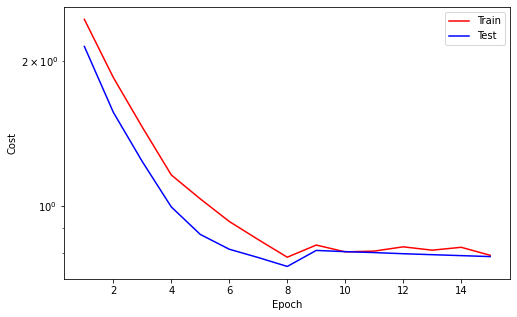

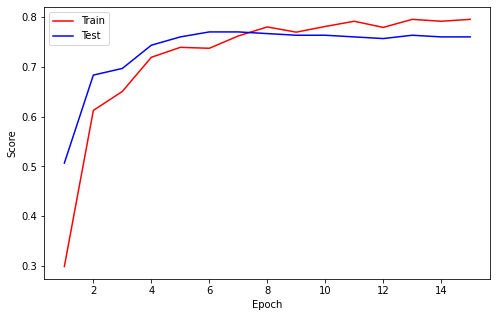

In [14]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# Predict

In [34]:
label2cat = train_set.classes

In [39]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [40]:
with torch.no_grad():
  model.eval()
  output = model(feature)
  pred = output.argmax(1)
pred

tensor([13,  3,  2,  8, 11,  7,  5,  8, 14,  9, 11,  7,  9,  0,  3, 11],
       device='cuda:0')

## Sanity Check

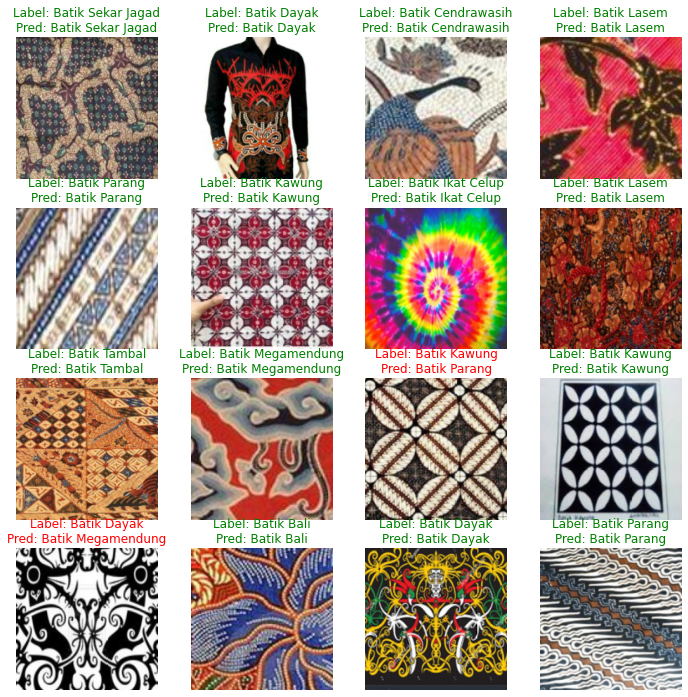

In [41]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for img, label, pred, ax in zip(feature, target, pred, axes.flatten()):
    ax.imshow(inverse_norm(img).permute(1,2,0).cpu())
    font = {"color": 'r'} if (pred!=label).any() else {"color": 'g'}
    ax.set_title(f"Label: {label2cat[label]}\nPred: {label2cat[pred]}", fontdict=font);
    ax.axis("off")